Transformed image shape: torch.Size([3, 256, 341])


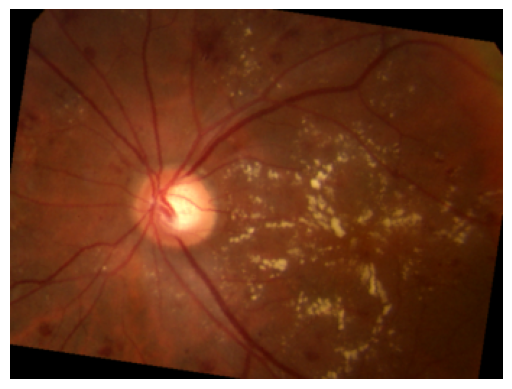

In [75]:
from PIL import Image
import torch
from torchvision import transforms

# Define the mean and std for normalization (ImageNet values)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Define the transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.Resize(256),  # Resize shorter side to 256 while maintaining aspect ratio
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),  # Normalize
])

# Load your image (make sure it's in a format PIL can work with)
image_path = "data/aptos2019/test_images/0a2b5e1a0be8.png"
image = Image.open(image_path)

# Apply the transformations
transformed_image = train_transforms(image)

# Check the shape of the transformed image (it will be a Tensor now)
print("Transformed image shape:", transformed_image.shape)

# If you want to visualize it, you can convert back to PIL (if needed)
# To undo the normalization and view the image:
import matplotlib.pyplot as plt
import numpy as np

# Denormalize for visualization (undo the normalization for display)
denormalized_image = transformed_image * torch.tensor(imagenet_std).view(3, 1, 1) + torch.tensor(imagenet_mean).view(3, 1, 1)

# Convert to numpy and permute dimensions to HWC (Height, Width, Channels)
denormalized_image = denormalized_image.permute(1, 2, 0).detach().numpy()

# Show image using matplotlib
plt.imshow(denormalized_image)
plt.axis('off')  # Hide axes
plt.show()


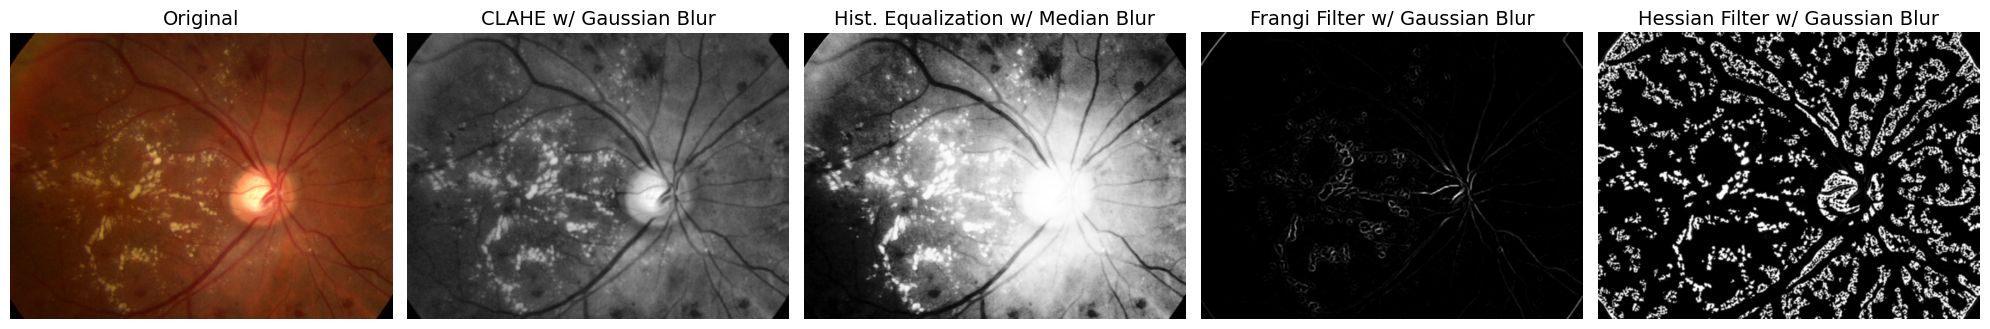

In [7]:
import cv2
import numpy as np
from skimage.filters import frangi, hessian
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

def frangi_preprocessing(img, use_median_blur=False):
    # Convert PIL to numpy
    img = np.array(img)

    # Convert to Grayscale (for vessel enhancement)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Frangi or Hessian
    vessel_img = frangi(img)  # or hessian(clahe_img)
    vessel_img = (vessel_img * 255).astype('uint8')

    if use_median_blur:
        vessel_img = cv2.medianBlur(vessel_img, 3)
    else:
        vessel_img = cv2.GaussianBlur(vessel_img, (3, 3), 1)

    # Convert back to PIL
    return Image.fromarray(vessel_img)


def hessian_preprocessing(img, use_median_blur=False):
    # Convert PIL to numpy
    img = np.array(img)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Frangi or Hessian Vessel Enhancement
    vessel_img = hessian(img)  # Apply Hessian on green channel
    vessel_img = (vessel_img * 255).astype('uint8')

    # Optional Blur (Gaussian or Median)
    if use_median_blur:
        vessel_img = cv2.medianBlur(vessel_img, 3)
    else:
        vessel_img = cv2.GaussianBlur(vessel_img, (3, 3), 1)

    # Convert back to PIL
    return Image.fromarray(vessel_img)

def clahe_gaussian_blur(img, use_median_blur=False):
    # Convert PIL to numpy
    img = np.array(img)

    # Convert to Grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)

    # Optional Blur (Gaussian by default)
    if use_median_blur:
        img_blur = cv2.medianBlur(img_clahe, 3)
    else:
        img_blur = cv2.GaussianBlur(img_clahe, (3, 3), 0)

     # Convert back to RGB (since the model expects 3 channels)
    img_rgb = cv2.cvtColor(img_blur, cv2.COLOR_GRAY2RGB)

    # Convert back to PIL
    return Image.fromarray(img_rgb)

def hist_equalization_median_blur(img, use_median_blur=True):
    # Convert PIL to numpy
    img = np.array(img)

    # Convert to Grayscale (Histogram Equalization works on single-channel images)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Histogram Equalization
    img_eq = cv2.equalizeHist(img_gray)

    # Apply Blur (Median by default)
    if use_median_blur:
        img_blur = cv2.medianBlur(img_eq, 3)
    else:
        img_blur = cv2.GaussianBlur(img_eq, (3, 3), 0)

    # Convert back to RGB (since the model expects 3 channels)
    img_rgb = cv2.cvtColor(img_blur, cv2.COLOR_GRAY2RGB)

    # Convert back to PIL
    return Image.fromarray(img_rgb)


image_path = "data/aptos2019/test_images/0a2b5e1a0be8.png"
# image_path = "data/aptos2019/train_images/0f96c358a250.png"
image = Image.open(image_path)
img = frangi_preprocessing(image)
images = [image, clahe_gaussian_blur(image), hist_equalization_median_blur(image), frangi_preprocessing(image), hessian_preprocessing(image)]
titles = ["Original", "CLAHE w/ Gaussian Blur", "Hist. Equalization w/ Median Blur", "Frangi Filter w/ Gaussian Blur", "Hessian Filter w/ Gaussian Blur"]

fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='grey')
    ax.set_title(titles[i], fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()


# # Show image using matplotlib
# plt.imshow(img)
# plt.axis('off')  # Hide axes
# plt.show()



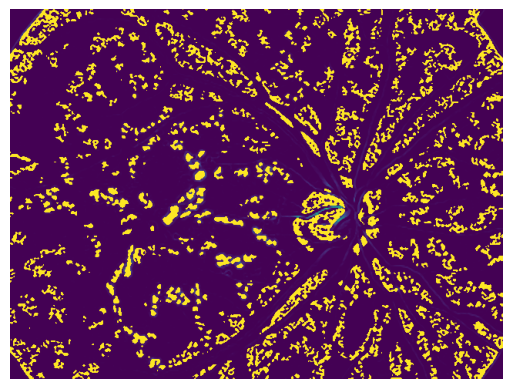

In [86]:
import cv2
import numpy as np
from skimage.filters import frangi, hessian
from PIL import Image, ImageOps


def hessian_preprocessing(img, use_median_blur=False):
    # Convert PIL to numpy
    img = np.array(img)

    # Extract Green Channel
    green = img[:, :, 1]  # 0=Red, 1=Green, 2=Blue

    # Frangi or Hessian Vessel Enhancement
    vessel_img = hessian(green)  # Apply Hessian on green channel
    vessel_img = (vessel_img * 255).astype('uint8')

    # Optional Blur (Gaussian or Median)
    if use_median_blur:
        vessel_img = cv2.medianBlur(vessel_img, 3)
    else:
        vessel_img = cv2.GaussianBlur(vessel_img, (3, 3), 1)

    # Convert back to PIL
    return Image.fromarray(vessel_img)

image_path = "data/aptos2019/test_images/0a2b5e1a0be8.png"
image = Image.open(image_path)
img = hessian_preprocessing(image, True)


# Show image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()



Transformed image shape: torch.Size([3, 224, 224])


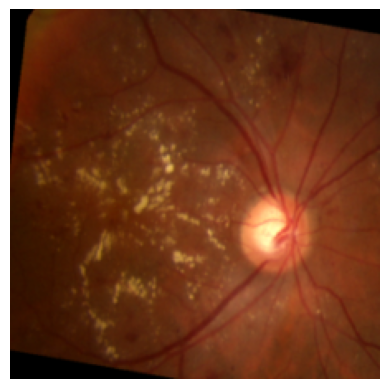

In [77]:
from PIL import Image
import torch
from torchvision import transforms

# Define the mean and std for normalization (ImageNet values)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Define the transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.Resize(256),  # Resize shorter side to 256 while maintaining aspect ratio
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)), 
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),  # Normalize
])

# Load your image (make sure it's in a format PIL can work with)
image_path = "data/aptos2019/test_images/0a2b5e1a0be8.png"
image = Image.open(image_path)

# Apply the transformations
transformed_image = train_transforms(image)

# Check the shape of the transformed image (it will be a Tensor now)
print("Transformed image shape:", transformed_image.shape)

# If you want to visualize it, you can convert back to PIL (if needed)
# To undo the normalization and view the image:
import matplotlib.pyplot as plt
import numpy as np

# Denormalize for visualization (undo the normalization for display)
denormalized_image = transformed_image * torch.tensor(imagenet_std).view(3, 1, 1) + torch.tensor(imagenet_mean).view(3, 1, 1)

# Convert to numpy and permute dimensions to HWC (Height, Width, Channels)
denormalized_image = denormalized_image.permute(1, 2, 0).detach().numpy()

# Show image using matplotlib
plt.imshow(denormalized_image)
plt.axis('off')  # Hide axes
plt.show()



In [9]:
import os

print(os.getcwd())

os.chdir('..')

# Print the new current working directory
print("New directory:", os.getcwd())

c:\Users\rylee\OneDrive\UCF\Medical_Image_Computing\Diabetic_Retinopathy\data
New directory: c:\Users\rylee\OneDrive\UCF\Medical_Image_Computing\Diabetic_Retinopathy


In [2]:
import cv2

image_path = "data/aptos2019/test_images/0a2b5e1a0be8.png"
image = cv2.imread(image_path)

# Print image size (height, width, channels)
print("Image size:", image.shape)  # (H, W, C)


AttributeError: 'NoneType' object has no attribute 'shape'

In [3]:
import cv2

image_path = "data/diabetic_retinopathy/test/1_left.jpeg"
image = cv2.imread(image_path)

# Print image size (height, width, channels)
print("Image size:", image.shape)  # (H, W, C)

AttributeError: 'NoneType' object has no attribute 'shape'